In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=Warning)

# Return Forecasting: Time Series Analysis & Modelling with CAD-PHY Exchange rate data.
In this notebook, you will load historical Canadian Dollar-Yen exchange rate futures data and apply time series analysis and modeling to determine whether there is any predictable behavior.

In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


# Initial Time-Series Plotting

 Start by plotting the "Settle" price. Do you see any patterns, long-term and/or short?

<AxesSubplot:title={'center':'CAD/JPY Exchange Rates'}, xlabel='Date'>

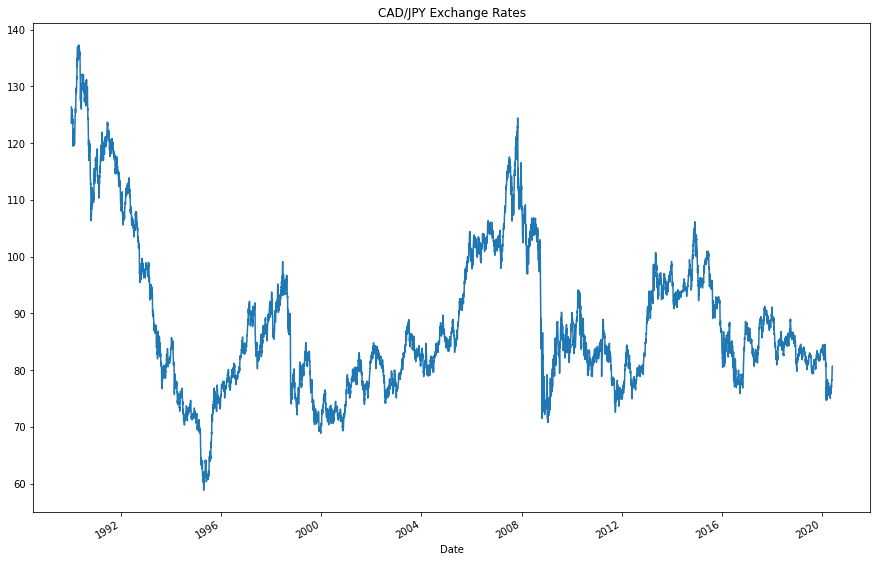

In [4]:
# Plot just the "Price" column from the dataframe:
cad_jpy_df.Price.plot(figsize=(15,10),title='CAD/JPY Exchange Rates')

**Question:** Do you see any patterns, long-term and/or short? 

**Answer:** Before the 2008 world crisis,  the exchange rate fluctuated significantly during the 90's (max of 120 and min of 60). From 1996 the exchange rate recovered from its lowest point (60) but with high volatility reaching its peak before the world crisis in 2008 (130). Since then, the behaviour was more stationary (between 70 and 90), despite a valuation period between 2012 and 2016 (max of 100).

---

# Decomposition Using a Hodrick-Prescott Filter

 Using a Hodrick-Prescott Filter, decompose the exchange rate price into trend and noise.

In [5]:
import statsmodels.api as sm

# Apply the Hodrick-Prescott Filter by decomposing the exchange rate price into two separate series:
cad_jpy_df_noise, cad_jpy_df_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [6]:
# Prepare cad_jpy_df to create a new data frame toadd columns for "noise" and "trend"
cad_jpy_df2 = cad_jpy_df.drop(['Open', 'High', 'Low'], axis=1)

In [7]:
# Create a dataframe of just the exchange rate price, and add columns for "noise" and "trend" series from above:
cad_jpy_df3 = pd.concat([cad_jpy_df2,cad_jpy_df_noise,cad_jpy_df_trend], axis="columns", join="inner")
cad_jpy_df3.rename(columns={'Price_cycle': 'noise', 'Price_trend': 'trend'}, inplace=True)
cad_jpy_df3.head()

,Price,noise,trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


<AxesSubplot:title={'center':'Price vs. Trend'}, xlabel='Date'>

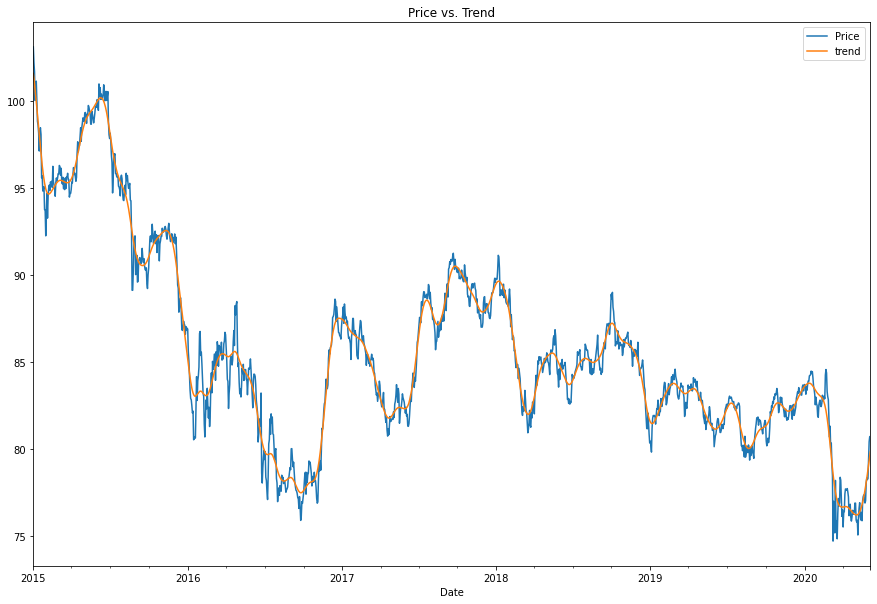

In [8]:
# Plot the Exchange Rate Price vs. the Trend for 2015 to the present
cad_jpy_df4 = cad_jpy_df3.drop(['noise'], axis=1)
cad_jpy_df4.loc['2015':'2020'].plot(figsize=(15,10),title='Price vs. Trend')

**Question:** Do you see any patterns, long-term and/or short?

**Answer:** Between 2015 and 2017, significant volatily of the price (Max=+100 and min=75), following a more stationary trend from 2017 until most recent date

<AxesSubplot:title={'center':'Noise'}, xlabel='Date'>

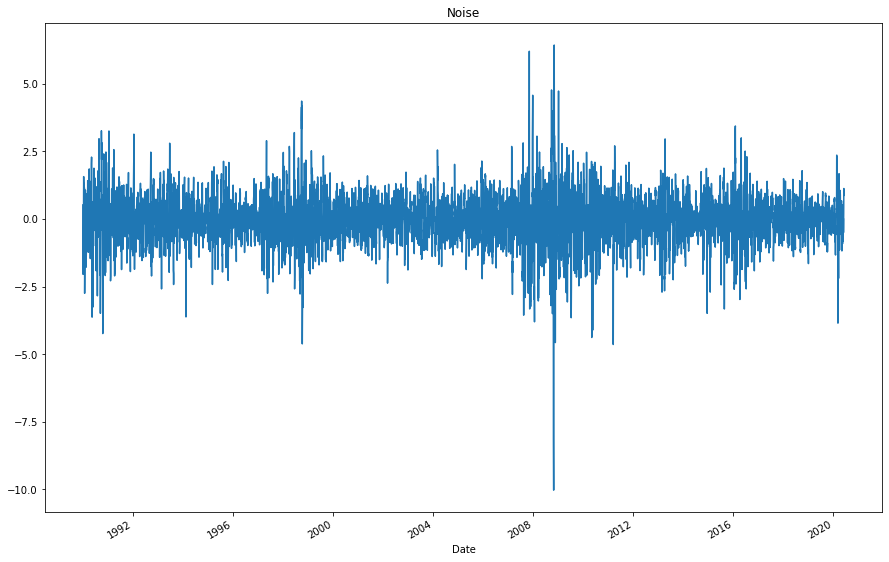

In [9]:
cad_jpy_df_noise.plot(figsize=(15,10),title='Noise')

---

# Forecasting Returns using an ARMA Model

Using exchange rate *Returns*, estimate an ARMA model

1. ARMA: Create an ARMA model and fit it to the returns data. Note: Set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [10]:
# Create a series using "Price" percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


<AxesSubplot:xlabel='Date'>

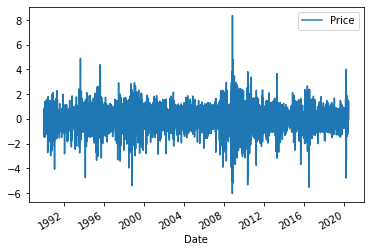

In [11]:
# Plot the percentage returns
returns.plot()

In [12]:
 # Import the ARMA model
from statsmodels.tsa.arima_model import ARMA

In [13]:
import statsmodels.api as sm

# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Sun, 01 May 2022   AIC                          19513.955
Time:                        21:24:07   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.200      0.000      -1.177      -0.533
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.031      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2033           +0.0000j            1.2033            0.5000
AR.2          -42.1699           +0.0000j           42.1699            0.5000
MA.1           -1.2127           +0.0000j            1.2127            0.5000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Returns Forecast'}>

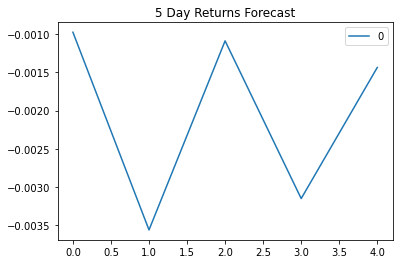

In [15]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

**Question:** Based on the p-value, is the model a good fit?

**Answer:** All ar and ma coefficients are below the 0.05 treshold of the P Values, which means these are significant, but the constant is above which means it can be excluded from this model. 

---

# Forecasting the Exchange Rate Price using an ARIMA Model

 1. Using the *raw* CAD/JPY exchange rate price, estimate an ARIMA model.
     1. Set P=5, D=1, and Q=1 in the model (e.g., ARIMA(df, order=(5,1,1))
     2. P= # of Auto-Regressive Lags, D= # of Differences (this is usually =1), Q= # of Moving Average Lags
 2. Output the ARIMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
 3. Plot a 5 day forecast for the Exchange Rate Price. What does the model forecast predict will happen to the Japanese Yen in the near term?

In [16]:
 # Run ARIMA model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(cad_jpy_df['Price'], order=(5,1,1))

C:\Users\nhc12\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\nhc12\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [17]:
 # Fit the model
results = model.fit()

In [18]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Sun, 01 May 2022   AIC                          17507.244
Time:                        21:24:30   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.855      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

<AxesSubplot:title={'center':'5 Day Futures Price Forecast'}>

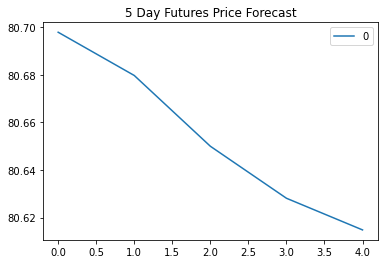

In [19]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

**Question:** What does the model forecast will happen to the Japanese Yen in the near term?

**Answer:** The Japanese Yen will devaluate in the near future according to the model, however all P values are above 0.05 which implies the model needs to be reviewed. Is not possible to conclude the coefficient is statistically significant. 

---

# Volatility Forecasting with GARCH

Rather than predicting returns, let's forecast near-term **volatility** of Japanese Yen exchange rate returns. Being able to accurately predict volatility will be extremely useful if we want to trade in derivatives or quantify our maximum loss.
 
Using exchange rate *Returns*, estimate a GARCH model. **Hint:** You can reuse the `returns` variable from the ARMA model section.

1. GARCH: Create an GARCH model and fit it to the returns data. Note: Set the parameters to p=2 and q=1: order=(2, 1).
2. Output the GARCH summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the volatility.

In [20]:
returns = cad_jpy_df.Price.pct_change() * 100
returns = returns.dropna()
returns.tail()

Date
2020-05-29    0.076697
2020-06-01    1.251756
2020-06-02    1.425508
2020-06-03    0.373134
2020-06-04    0.012392
Name: Price, dtype: float64

In [21]:
from arch import arch_model
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

In [22]:
# Fit the GARCH Model
res = model.fit(disp="off")

In [23]:
 # Summarize the model results
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Sun, May 01 2022   Df Residuals:                     7928
Time:                        21:24:43   Df Model:                            0
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

In [24]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [25]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
forecasts = res.forecast(start='2020-06-04', horizon=forecast_horizon)
forecasts

In [26]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566029,12.573718,12.581301,12.588778,12.596153


In [27]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566029
h.2,12.573718
h.3,12.581301
h.4,12.588778
h.5,12.596153


<AxesSubplot:title={'center':'5 Day Forecast of Volatility'}>

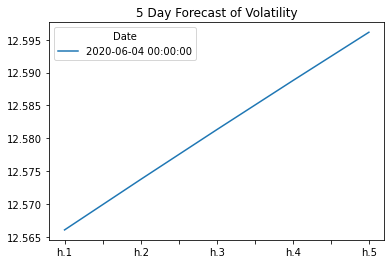

In [28]:
# Plot the final forecast
final.plot(title="5 Day Forecast of Volatility")

**Question:** What does the model forecast will happen to volatility in the near term?

**Answer:** All coefficients are below the P Values treshold of 0.05 which means these are significant. Due to the timeframe of 5 days, the graph shows a high volatility. 

---

# Conclusions

1. Based on your time series analysis, would you buy the yen now?
    * Since the models predict a devaluation of the Yen, it would be the right time to buy considering the low price to take advantage to sell once the price increases. However, its important to consider that the results of the ARIMA model that predict these prices ( specifically the P Values) are all above 0.05 which allows to conclude that these are not statistically significant therefore its important to reconsider whether to buy based on this information. 

2. Is the risk of the yen expected to increase or decrease?
    * The model is showing negative returns and high volatility, being this last measure the most significant and reliable.

3. Based on the model evaluation, would you feel confident in using these models for trading?
    * Since the coefficients are below the P values treshold for both Price and returns forecast, these models will need to be reassesed. Additionally, the volatility forecasting done with the GARCH methodology shows high volatilyt which implies the need to revise the forecasting models. 